## Packages

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

## Data Pre-processing

In [36]:
# # startDate , as per our convenience we can modify
# start_date = datetime.datetime(2018, 1, 1)
 
# # endDate , as per our convenience we can modify
# end_date = datetime.datetime(2024, 1, 1)
# btc_info = yf.Ticker("BTC-USD")
 
# # pass the parameters as the taken dates for start and end
# df = btc_info.history(start = start_date, end = end_date)
# df

In [37]:
df = pd.read_csv('BTC-USD.csv')
df.columns = ['date','open', 'high', 'low', 'close', 'adj_close', 'vol']
df = df.sort_values(by = ['date'], ascending=True)
df.index = pd.to_datetime(df['date'])
df.drop(['date','adj_close'], axis=1, inplace=True)
df

,open,high,low,close,vol
date,,,,,
2017-12-31,12897.700195,14377.400391,12755.599609,14156.400391,12136299520
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,21783199744
...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,26000021055


In [38]:
# Prepare the volume and price differences, normalize volume
BTC_vol = df["vol"].values
df_diff = df.diff().dropna() # difference of df
df_diff["vol"] = np.log(1 + BTC_vol[:-1])  # Shifted by 1 to align with diff
df_aligned = df.loc[df_diff.index]
mask_train = (df_diff.index >= "2018-01-01") & (df_diff.index <= "2022-12-31")
df_train = df_diff.loc[mask_train].copy()
# Use df_aligned to ensure the indexes match
train_close = df_aligned.loc[mask_train, "close"].values

# Since indexes are aligned, this operation should now work without error
df_train["Relative_Close"] = train_close / train_close[0]

df_train

,open,high,low,close,vol,Relative_Close
date,,,,,,
2018-01-01,1214.500000,-265.200196,399.100586,-499.200196,23.219467,1.000000
2018-01-02,-487.200195,1332.399414,8.899414,1324.899414,23.054555,1.097011
2018-01-03,1353.200195,128.200196,1680.900391,218.900391,23.547415,1.113039
2018-01-04,292.500000,166.900390,-322.299805,398.200195,23.548915,1.142196
2018-01-05,206.500000,1965.499024,680.599610,1830.299805,23.804405,1.276213
...,...,...,...,...,...,...
2022-12-27,77.041016,39.722656,-170.296875,-202.630860,23.198708,1.224056
2022-12-28,-202.890625,-191.675781,-144.515625,-164.601562,23.480016,1.212003
2022-12-29,-164.078125,-116.414063,11.126953,89.769531,23.556815,1.218576


In [39]:
mask_test = (df_diff.index >= "2023-01-01") & (df_diff.index <= "2023-12-31")  # December 2018 for testing
df_test = df_diff.loc[mask_test].copy()
test_close = df_aligned.loc[mask_test, "close"].values
df_test["Relative_Close"] = test_close / train_close[0]
df_test

,open,high,low,close,vol,Relative_Close
date,,,,,,
2023-01-01,-55.759765,1.453125,3.714844,77.583984,23.142672,1.217312
2023-01-02,77.595703,128.904297,50.994141,63.390625,22.947280,1.221954
2023-01-03,63.337890,1.103516,50.142578,-8.613281,23.216287,1.221323
2023-01-04,-8.642578,204.138672,45.392578,183.380859,23.355376,1.234751
2023-01-05,183.267578,-80.564454,122.519531,-26.501953,23.636798,1.232810
...,...,...,...,...,...,...
2023-12-27,-1081.378906,79.984375,491.093750,922.453125,24.125358,3.180949
2023-12-28,949.730469,121.621094,150.968750,-815.000000,23.952525,3.121273
2023-12-29,-853.554688,-680.457031,-894.488281,-528.453125,23.858416,3.082579


### Generate LSTM Dataset 

In [40]:
# Generate dataset function for LSTM
def generate_dataset_LSTM(df, seq_len):
    X_list, y_list = [], []
    for i in range(len(df) - seq_len):
        X_list.append(df.iloc[i:(i+seq_len), :].values)
        y_list.append(df["close"].iloc[i + seq_len])
    return np.array(X_list), np.array(y_list)

In [41]:
LAG = 5 # Example: Use the past # days to predict the next day
# Prepare training and test datasets
X_train_LSTM, y_train_LSTM = generate_dataset_LSTM(df_train, LAG)
X_test_LSTM, y_test_LSTM = generate_dataset_LSTM(pd.concat((df_train.iloc[-LAG:], df_test)), LAG)

In [42]:
X_train_LSTM.shape

(1821, 5, 6)

## LSTM (unchanged from minute-by-minute example)

In [43]:
# model architecture
tf.keras.utils.set_random_seed(4012)
model = Sequential([
    LSTM(8, return_sequences=True, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])),
    LSTM(8, dropout=0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# train the dataset
model.fit(X_train_LSTM, y_train_LSTM, batch_size=64, epochs=30, shuffle=True) 

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1032241.3750
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1032237.4375 
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032238.6250 
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032237.0000 
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032239.5000 
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032238.0625 
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032238.8125 
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032236.6250 
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032236.4375 
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032237.0000 
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032240.6250 
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032229.5000 
Epoch 13/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032222.9375 
Epoch 14/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1032225.8125 

In [44]:
# Predict and evaluate
pred_LSTM = np.squeeze(model.predict(X_test_LSTM))
print("Test MSE:", np.mean((pred_LSTM - y_test_LSTM)**2))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test MSE: 429782.46200238826


In [45]:
pred_LSTM, y_test_LSTM

(array([-1.6267673 , -1.8590935 , -0.7521943 ,  0.39462256, -1.3486447 ,
         2.6151738 ,  2.5996366 ,  0.461742  ,  2.8598819 ,  2.7544456 ,
         2.9805176 ,  2.4974442 ,  3.179704  ,  3.136257  ,  2.5574641 ,
         2.8329504 ,  2.8124099 ,  2.7476022 ,  2.2970695 ,  1.8905474 ,
         1.2788013 , -1.9645268 , -1.6841697 , -1.0426533 ,  2.3203177 ,
         1.5621464 ,  2.1584015 ,  1.9737808 ,  0.9232025 ,  1.4701566 ,
         0.28269875,  1.0087734 ,  0.48427355,  2.9787574 ,  1.9379109 ,
        -0.8279846 ,  0.409297  , -1.2811528 , -1.8827296 , -2.0262132 ,
        -1.8184371 , -1.7829472 ,  1.903351  , -0.3996014 , -1.8604189 ,
        -1.3137926 ,  1.8373326 ,  2.7984133 ,  2.1070263 ,  2.7111406 ,
         2.2543414 , -0.6051298 ,  1.1260966 , -0.9930212 ,  0.99082506,
         1.0464212 ,  0.33296844, -2.222577  , -0.71073484, -1.9871515 ,
        -1.1098934 ,  2.9071229 ,  2.3398242 ,  1.009755  ,  1.3111655 ,
        -1.5591894 , -1.9012166 , -1.788619  ,  1.2

## MLP (flattening the previous 5-day data)

In [46]:
def gen_dataset_MLP(df, seq_len):
    df_X_extract = df[['open','high','low','vol','Relative_Close']]
    df_X = pd.DataFrame(columns=np.arange(0, (df.shape[1]-1)*seq_len))
    df_y = df[['close']][seq_len:]
    for i in range(len(df) - seq_len):
        df_i = pd.DataFrame(df_X_extract.iloc[i:(i+seq_len)].values.flatten(), columns=[0])
        df_X = pd.concat([df_X, df_i.T], axis=0)
    df_X = df_X.reset_index(drop=True)
    return df_X, df_y

In [94]:
X_train_MLP, y_train_MLP = gen_dataset_MLP(df_train, 5)

In [ ]:
X_test_MLP, y_test_MLP = gen_dataset_MLP(df_test, 5)

In [51]:
X_train_MLP.shape

(1821, 25)

In [54]:
# # Model Pred rescale
# scaled_pred_MLP = model2.predict(X_test_MLP)
# scaled_pred_MLP_reshaped = np.zeros((scaled_pred_MLP.shape[0], df_test.shape[1]))
# scaled_pred_MLP_reshaped[:, 0] = scaled_pred_MLP[:, 0]  # Assuming the first column is the predicted closing price
# pred_MLP_reshaped = scaler.inverse_transform(scaled_pred_MLP_reshaped) # Apply inverse transformation
# pred_MLP = pred_MLP_reshaped[:, 0]
# pred_MLP

In [55]:
# # y_test_MLP rescale
# scaled_actual_MLP_reshaped = np.zeros((scaled_pred_MLP.shape[0], df_test.shape[1]))
# scaled_actual_MLP_reshaped[:, 0] = y_test_MLP['close']  # Assuming the first column is the predicted closing price
# actual_MLP_reshaped = scaler.inverse_transform(scaled_actual_MLP_reshaped) # Apply inverse transformation
# actual_MLP = actual_MLP_reshaped[:, 0]
# actual_MLP

### Test on MLP Models

#### 1. Number of Hidden Layers & Activation Functions

In [61]:
def build_model(num_layers,act_fcn, train_df = X_train_MLP):
    # tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(4012)
    
    model = Sequential()
    model.add(tf.keras.Input(shape=(train_df.shape[1],)))
    model.add(Dense(64, activation=act_fcn))
    
    for _ in range(num_layers):
        model.add(Dense(64, activation=act_fcn))

    # model.add(Dropout(0.5))
    model.add(Dense(1))
    return model

num_layers_list = [0, 1, 2, 3]  
activation_fcns = ['relu','sigmoid']
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
no_lay_df = pd.DataFrame(columns = ['No_layers','Act_Fcns','MSE','MAE'])

for num_layers in num_layers_list:
    for act_fcn in activation_fcns:
        model = build_model(num_layers, act_fcn)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

        model.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)
        pred_MLP = model.predict(X_test_MLP)
        mse_MLP = mse(y_test_MLP, pred_MLP).numpy()
        mae_MLP = mae(y_test_MLP, pred_MLP).numpy()

        no_lay_df_new = pd.DataFrame(dict(No_layers=[num_layers+1], Act_Fcns=[act_fcn],MSE=[mse_MLP],MAE=[mae_MLP]))
        no_lay_df = pd.concat([no_lay_df, no_lay_df_new], axis=0, ignore_index=True)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.0000e+00 - loss: 1284028.5000
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.0000e+00 - loss: 1108007.6250
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.0000e+00 - loss: 1061344.1250
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.0000e+00 - loss: 1032253.4375
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.0000e+00 - loss: 1012849.6875
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.0000e+00 - loss: 998990.5000
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.0000e+00 - loss: 987880.3125
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.0000e+00 - loss: 978449.8125
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.0000e+00 - loss: 970188.2500
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.0000e+00 - loss: 963388.5625
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━

In [62]:
no_lay_df

,No_layers,Act_Fcns,MSE,MAE
0,1,relu,487503.06250,498.942200
1,1,sigmoid,435768.12500,442.824188
2,2,relu,667014.37500,597.638367
3,2,sigmoid,433388.84375,441.185211
4,3,relu,625944.00000,587.523376
5,3,sigmoid,433203.28125,442.001556
6,4,relu,553405.75000,542.691040
7,4,sigmoid,430264.87500,440.325348


In [63]:
no_lay_df[no_lay_df['MSE']==min(no_lay_df['MSE'])]

,No_layers,Act_Fcns,MSE,MAE
7,4,sigmoid,430264.875,440.325348


In [64]:
no_lay_df[no_lay_df['MAE']==min(no_lay_df['MAE'])]

,No_layers,Act_Fcns,MSE,MAE
7,4,sigmoid,430264.875,440.325348


> best model: sigmoid & 4 layer

#### 2. Number of Neurons & Dropout Value

In [ ]:
def build_model(neuron, dropout,act_fcn='sigmoid', train_df = X_train_MLP):
    tf.keras.utils.set_random_seed(4012)
    model = Sequential()
    model.add(tf.keras.Input(shape=(train_df.shape[1],)))
    model.add(Dense(neuron, activation=act_fcn))
    model.add(Dense(neuron, activation=act_fcn))
    model.add(Dense(neuron, activation=act_fcn))
    model.add(Dense(neuron, activation=act_fcn))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    return model

dropouts = [0, 0.2, 0.5, 0.7]
neurons = [32, 64, 128]
# activation_fcns = ['relu','sigmoid']
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
test_MLP_df = pd.DataFrame(columns = ['Neurons', 'Dropout','MSE','MAE'])

for dropout in dropouts:
    for neuron in neurons:
        model = build_model(neuron, dropout)

        model.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)
        pred_MLP = model.predict(X_test_MLP)
        mse_MLP = mse(y_test_MLP, pred_MLP).numpy()
        mae_MLP = mae(y_test_MLP, pred_MLP).numpy()

        test_MLP_df_new = pd.DataFrame(dict(Neurons=[neuron],Dropout=[dropout],MSE=[mse_MLP],MAE=[mae_MLP]))
        test_MLP_df = pd.concat([test_MLP_df, test_MLP_df_new], axis=0, ignore_index=True)

In [85]:
test_MLP_df

,Neurons,Dropout,MSE,MAE
0,32,0,433521.81250,440.357544
1,64,0,430264.87500,440.325348
2,128,0,445350.75000,459.292328
3,32,0.2,436060.75000,442.959839
4,64,0.2,434487.18750,444.353119
5,128,0.2,445121.18750,459.613007
6,32,0.5,433071.96875,441.838196
7,64,0.5,438215.65625,444.468658
8,128,0.5,449219.65625,454.080383
9,32,0.7,434921.96875,442.177643


In [86]:
test_MLP_df[test_MLP_df['MSE']==min(test_MLP_df['MSE'])]

,Neurons,Dropout,MSE,MAE
1,64,0,430264.875,440.325348


In [87]:
test_MLP_df[test_MLP_df['MAE']==min(test_MLP_df['MAE'])]

,Neurons,Dropout,MSE,MAE
1,64,0,430264.875,440.325348


#### Best Model 

In [ ]:
# model architecture for MLP: 4 64-nueron layers
tf.keras.utils.set_random_seed(4012)
model2 = Sequential()
model2.add(tf.keras.Input(shape=(X_train_MLP.shape[1],))) # input features
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dense(64, activation='sigmoid'))
# model2.add(Dropout(0.5))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model2.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)

In [96]:
mse = tf.keras.losses.MeanSquaredError()
pred_MLP = model2.predict(X_test_MLP)
mse_MLP = mse(y_test_MLP, pred_MLP)
mse_LSTM = mse(y_test_LSTM, pred_LSTM)

mse_MLP, mse_LSTM

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(<tf.Tensor: shape=(), dtype=float32, numpy=430264.88>,
 <tf.Tensor: shape=(), dtype=float32, numpy=429782.5>)

Text(0, 0.5, 'Difference in Price')

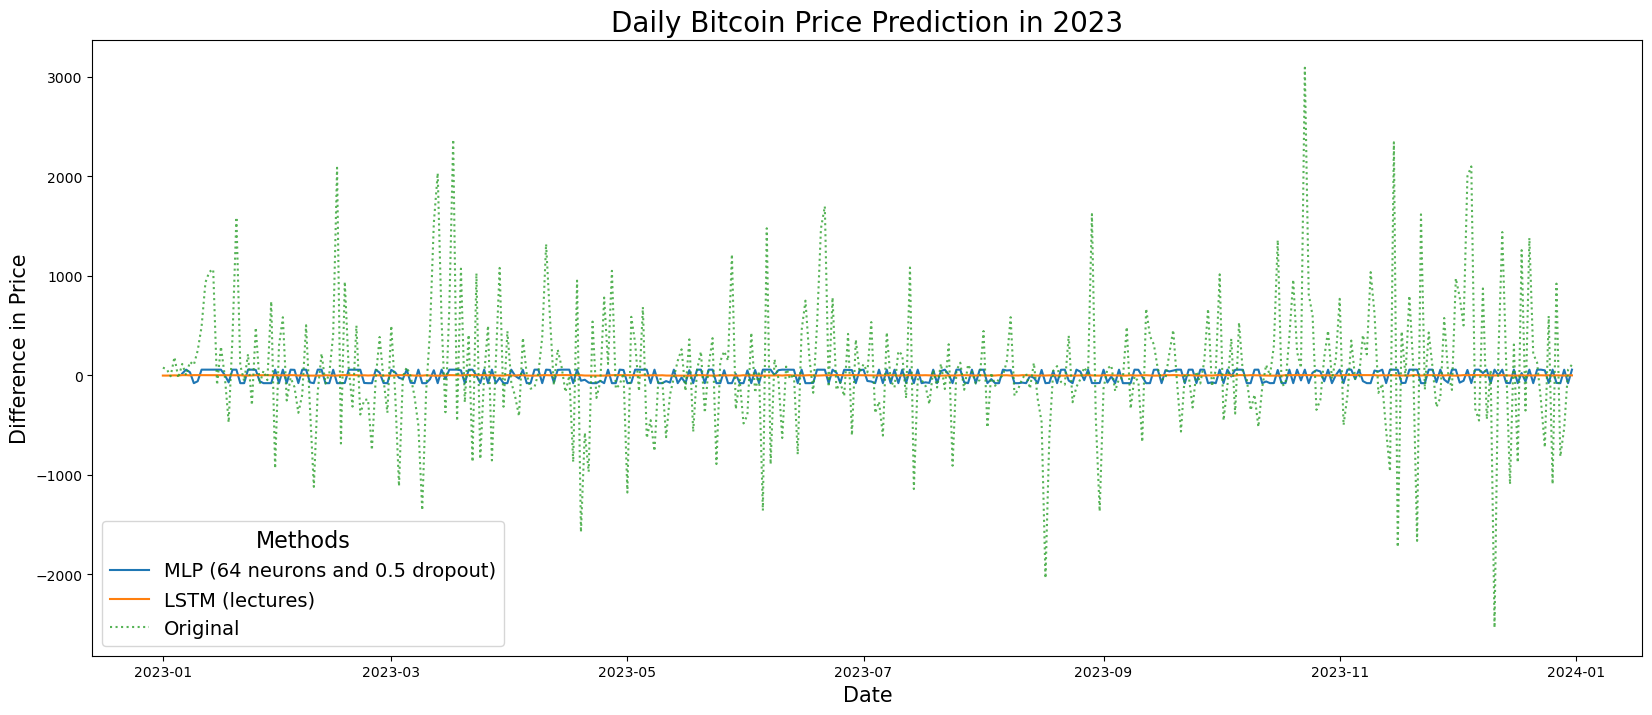

In [97]:
fig = plt.figure(figsize=(20,8))
plt.plot(np.array(df_test.index)[5:], pred_MLP, label='MLP (64 neurons and 0.5 dropout)')
plt.plot(np.array(df_test.index), pred_LSTM, label='LSTM (lectures)')
plt.plot(np.array(df_test.index), df_test["close"], label='Original', linestyle='dotted', alpha=0.8)
plt.legend(title='Methods',title_fontsize=16, fontsize=14)
plt.title('Daily Bitcoin Price Prediction in 2023', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)

Text(0, 0.5, 'Difference in Price')

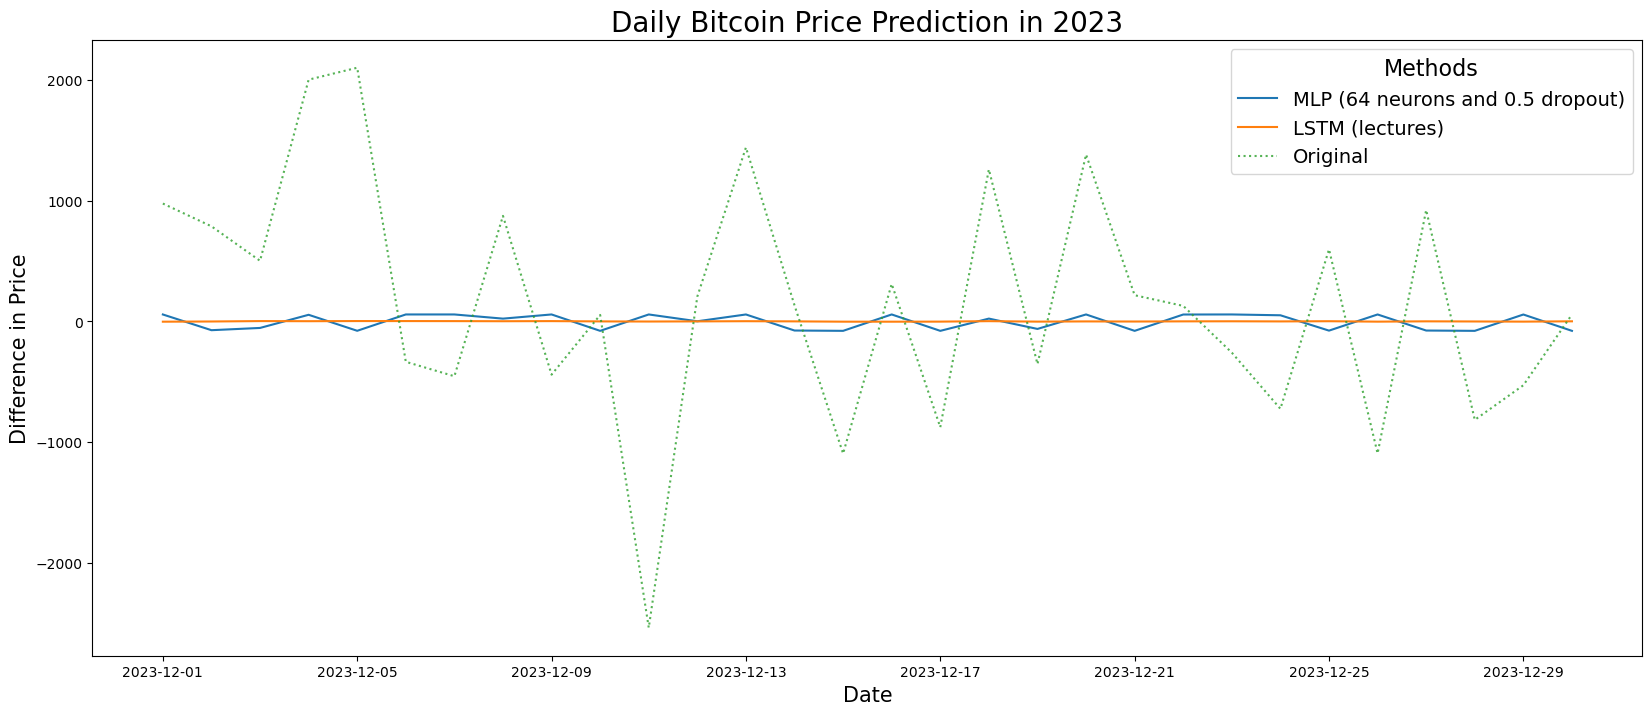

In [98]:
fig = plt.figure(figsize=(20,8))
plt.plot(np.array(df_test.index)[-31:-1], pred_MLP[-31:-1], label='MLP (64 neurons and 0.5 dropout)')
plt.plot(np.array(df_test.index)[-31:-1], pred_LSTM[-31:-1], label='LSTM (lectures)')
plt.plot(np.array(df_test.index)[-31:-1], df_test["close"][-31:-1], label='Original', linestyle='dotted', alpha=0.8)
plt.legend(title='Methods',title_fontsize=16, fontsize=14)
plt.title('Daily Bitcoin Price Prediction in 2023', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)

## MLP (median of past 5-day data)

In [114]:
def gen_dataset_MLP(df, seq_len):
    df_X_extract = df[['open','high','low','vol','Relative_Close']]
    df_X = pd.DataFrame(columns=['open','high','low','vol','Relative_Close'])
    df_y = df[['close']][seq_len:]
    for i in range(len(df) - seq_len):
        df_i = pd.DataFrame(df_X_extract.iloc[i:(i+seq_len)].median(axis=0), columns=[0])
        df_X = pd.concat([df_X, df_i.T], axis=0)
    df_X = df_X.reset_index(drop=True)
    return df_X, df_y

In [115]:
X_train_MLP, y_train_MLP = gen_dataset_MLP(df_train, 5)

In [116]:
X_test_MLP, y_test_MLP = gen_dataset_MLP(df_test, 5)

### Test on MLP Models

#### 1. Number of Hidden Layers & Activation Functions

In [ ]:
def build_model(num_layers,act_fcn, train_df = X_train_MLP):
    # tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(4012)
    
    model = Sequential()
    model.add(tf.keras.Input(shape=(train_df.shape[1],)))
    model.add(Dense(64, activation=act_fcn))
    
    for _ in range(num_layers):
        model.add(Dense(64, activation=act_fcn))

    # model.add(Dropout(0.5))
    model.add(Dense(1))
    return model

num_layers_list = [0, 1, 2, 3]  
activation_fcns = ['relu','sigmoid']
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
no_lay_df = pd.DataFrame(columns = ['No_layers','Act_Fcns','MSE','MAE'])

for num_layers in num_layers_list:
    for act_fcn in activation_fcns:
        model = build_model(num_layers, act_fcn)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

        model.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)
        pred_MLP = model.predict(X_test_MLP)
        mse_MLP = mse(y_test_MLP, pred_MLP).numpy()
        mae_MLP = mae(y_test_MLP, pred_MLP).numpy()

        no_lay_df_new = pd.DataFrame(dict(No_layers=[num_layers+1], Act_Fcns=[act_fcn],MSE=[mse_MLP],MAE=[mae_MLP]))
        no_lay_df = pd.concat([no_lay_df, no_lay_df_new], axis=0, ignore_index=True)

In [122]:
no_lay_df

,No_layers,Act_Fcns,MSE,MAE
0,1,relu,430038.50000,447.105988
1,1,sigmoid,435778.84375,443.449921
2,2,relu,434150.96875,454.985291
3,2,sigmoid,435960.71875,444.391235
4,3,relu,465949.59375,479.747437
5,3,sigmoid,440578.87500,447.449951
6,4,relu,482007.90625,490.931213
7,4,sigmoid,441485.68750,450.390533


In [123]:
no_lay_df[no_lay_df['MSE']==min(no_lay_df['MSE'])]

,No_layers,Act_Fcns,MSE,MAE
0,1,relu,430038.5,447.105988


> best model: relu & 1 layer

#### 2. Number of Neurons & Dropout Value

In [ ]:
def build_model(neuron, dropout,act_fcn='relu', train_df = X_train_MLP):
    tf.keras.utils.set_random_seed(4012)
    model = Sequential()
    model.add(tf.keras.Input(shape=(train_df.shape[1],)))
    model.add(Dense(neuron, activation=act_fcn))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    return model

dropouts = [0, 0.2, 0.5, 0.7]
neurons = [32, 64, 128]
# activation_fcns = ['relu','sigmoid']
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
test_MLP_df = pd.DataFrame(columns = ['Neurons', 'Dropout','MSE','MAE'])

for dropout in dropouts:
    for neuron in neurons:
        model = build_model(neuron, dropout)

        model.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)
        pred_MLP = model.predict(X_test_MLP)
        mse_MLP = mse(y_test_MLP, pred_MLP).numpy()
        mae_MLP = mae(y_test_MLP, pred_MLP).numpy()

        test_MLP_df_new = pd.DataFrame(dict(Neurons=[neuron],Dropout=[dropout],MSE=[mse_MLP],MAE=[mae_MLP]))
        test_MLP_df = pd.concat([test_MLP_df, test_MLP_df_new], axis=0, ignore_index=True)

In [130]:
test_MLP_df

,Neurons,Dropout,MSE,MAE
0,32,0,429491.12500,445.317261
1,64,0,430038.50000,447.105988
2,128,0,427730.03125,446.690155
3,32,0.2,430946.75000,445.554138
4,64,0.2,430533.28125,446.492279
5,128,0.2,428784.28125,446.600525
6,32,0.5,432847.12500,444.612762
7,64,0.5,431997.78125,446.229431
8,128,0.5,430132.28125,445.753510
9,32,0.7,433562.34375,444.690887


In [131]:
test_MLP_df[test_MLP_df['MSE']==min(test_MLP_df['MSE'])]

,Neurons,Dropout,MSE,MAE
2,128,0,427730.03125,446.690155


### Best Model

In [ ]:
# model architecture for MLP: 4 64-nueron layers
tf.keras.utils.set_random_seed(4012)
model2 = Sequential()
model2.add(tf.keras.Input(shape=(X_train_MLP.shape[1],))) # input features
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model2.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)

In [135]:
mse = tf.keras.losses.MeanSquaredError()
pred_MLP = model2.predict(X_test_MLP)
mse_MLP = mse(y_test_MLP, pred_MLP)
mse_LSTM = mse(y_test_LSTM, pred_LSTM)
pd.DataFrame(dict(Methods=['MLP','LSTM'],MSE=[mse_MLP.numpy(), mse_LSTM.numpy()]))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


,Methods,MSE
0,MLP,427730.03125
1,LSTM,429782.50000


Text(0, 0.5, 'Difference in Price')

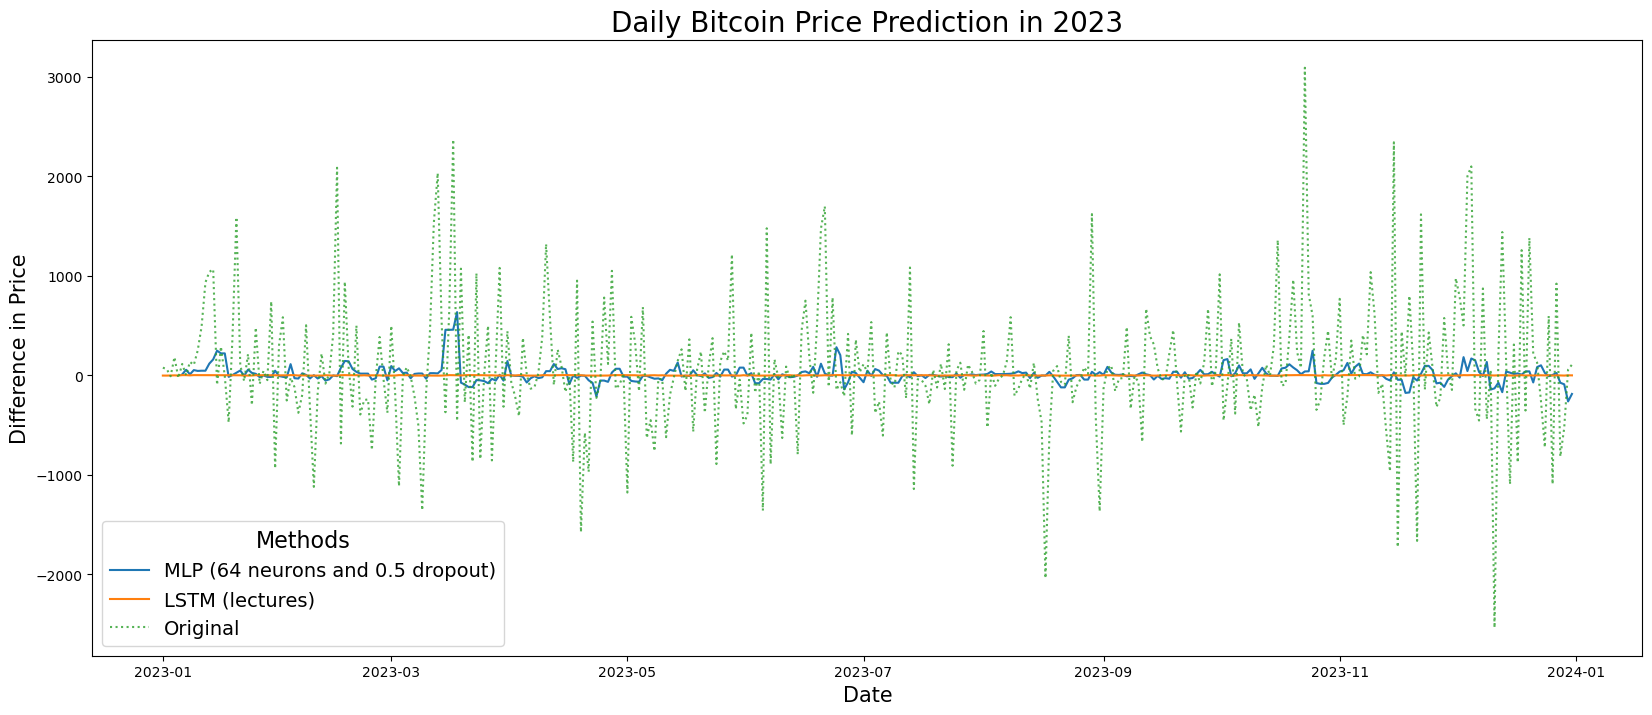

In [136]:
fig = plt.figure(figsize=(20,8))
plt.plot(np.array(df_test.index)[5:], pred_MLP, label='MLP (64 neurons and 0.5 dropout)')
plt.plot(np.array(df_test.index), pred_LSTM, label='LSTM (lectures)')
plt.plot(np.array(df_test.index), df_test["close"], label='Original', linestyle='dotted', alpha=0.8)
plt.legend(title='Methods',title_fontsize=16, fontsize=14)
plt.title('Daily Bitcoin Price Prediction in 2023', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)

Text(0, 0.5, 'Difference in Price')

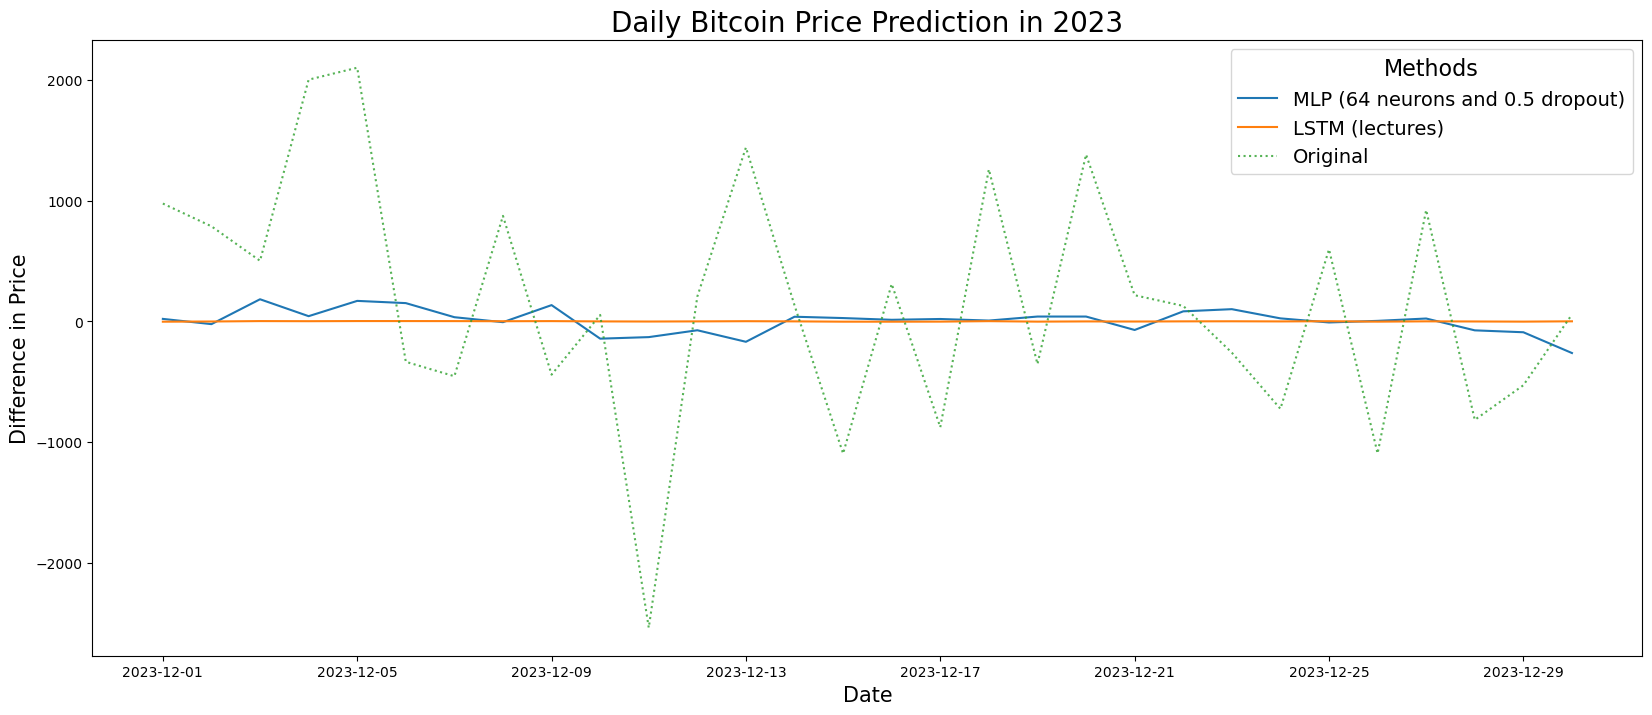

In [138]:
fig = plt.figure(figsize=(20,8))
plt.plot(np.array(df_test.index)[-31:-1], pred_MLP[-31:-1], label='MLP (64 neurons and 0.5 dropout)')
plt.plot(np.array(df_test.index)[-31:-1], pred_LSTM[-31:-1], label='LSTM (lectures)')
plt.plot(np.array(df_test.index)[-31:-1], df_test["close"][-31:-1], label='Original', linestyle='dotted', alpha=0.8)
plt.legend(title='Methods',title_fontsize=16, fontsize=14)
plt.title('Daily Bitcoin Price Prediction in 2023', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)